<a href="https://colab.research.google.com/github/BKHV/risk_models/blob/master/PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
RANDOM_STATE = 42

### Подгружаем данные

По условиям задания, данные уже разделены на train и test. В практике генеральная совокупность данных делиться на следующие выборки:
  <ul>
   <li><b>DEV</b> - выборка для разработки модели</li>
   <li><b>OOT</b> (out of time) - максимально свежие данные, предназанченные для тестирвования/валидации с целью понимания, что было бы если бы мы модель использовали сейчас.</li>
   <li><b>OOS</b> (out of samle) - выборка предназанченная для тестирования/валидации, совпадающая по временому горизонту с выборкой для разработки. Формирование выборки OOS произовдится со стратификацией уровня дефолта относительно DEV</li>
  </ul>
<p><img src="https://dsbattle.com/assets/images/dev-oos-oot.png" width="700" alt="lorem"></p>

<i>Стратификация — метод выбора подмножества объектов из генеральной совокупности, разбитой на подмножества (страты). При стратификации объекты выбираются таким образом, чтобы итоговая выборка сохраняла соотношения размеров страт.</i>

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv

--2021-02-06 06:06:29--  https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv.1’

PD-data-train.csv.1 100%[===================>]   5.08M  29.9MB/s    in 0.2s    

2021-02-06 06:06:30 (29.9 MB/s) - ‘PD-data-train.csv.1’ saved [5329268/5329268]

--2021-02-06 06:06:30--  https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28K) [text/plain]
Saving t

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')

Семплы и размеры выборок

In [ ]:
train_df.head()

record_id  ar_revenue  ...  ul_systematizing_flg  default_12m
0          7  52996000.0  ...                     0            0
1         13         NaN  ...                     0            0
2         18         NaN  ...                     0            0
3         22  32049000.0  ...                     0            0
4         23  16458000.0  ...                     0            0

[5 rows x 37 columns]

In [ ]:
train_df.shape

(32395, 37)

In [ ]:
test_df.head()

record_id   ar_revenue  ...  ul_strategic_flg  ul_systematizing_flg
0        196   39103000.0  ...                 0                     0
1       1196          NaN  ...                 0                     0
2       2813   54174000.0  ...                 0                     0
3       4385    1904000.0  ...                 0                     0
4       6479  225584000.0  ...                 0                     0

[5 rows x 36 columns]

In [ ]:
test_df.shape

(200, 36)

Уровень дефолт-рейта в выборке = 6,4547%

In [ ]:
train_df['default_12m'].values.mean()

0.06454699799351751

PD модель должна возвращать ожидаемый уровень дефолта, чтобы избежать переоценки или недооценки кредитного риска. Для этого делается калибровка модели (в текущем задании это делать не нужно). Бывает два типа калибровки:
  <ul>
   <li><b>TTC</b> (through the cycle) - модель калибруется на среднее значение PD за полный экономический цикл, чтобы в долгосрочной перспективе адекватно оценивать риск, независимо от стадии экономического цикла.</li>
   <li><b>PIT</b> (point in time) - модель калибруется на текущий уровень дефолта (обычно за полседний доступный год), чтобы адекватно оценивать рисккраткосрочной перспективе в текущей стадии экономического цикла.</li>
  </ul>

  <p><img src="https://dsbattle.com/assets/images/calib.png" width="700" alt="lorem"></p>

### Сгенерируем новые относительные признаки 

Объединим обучающую и тестовую выборки для того, чтобы сгенерировать новые признаки сразу для всех выборок

In [ ]:
df = pd.concat([train_df, test_df], sort=False)

In [ ]:
TL = df.ab_long_term_liabilities + df.ab_other_borrowings + df.ab_short_term_borrowing
TA = df.ab_own_capital + df.ab_borrowed_capital
STD = df.ab_short_term_borrowing
STFD = df.ab_short_term_borrowing
CA = df.ab_mobile_current_assets
FCA = df.ab_mobile_current_assets - df.ab_inventory
GY = df.ar_sale_profit

df['r_1_a'] =  df.ar_revenue / (df.ab_accounts_receivable/12) 
df['r_2_a'] = df.ar_sale_cost / (df.ab_inventory/12)
df['r_3_a'] = df.ar_selling_expenses / (df.ar_total_expenses/12)
df['r_4_a'] = df.ar_revenue / TA -TL
df['r_5_a'] = df.ar_revenue / (df.ab_immobilized_assets/12)
df['r_6_a'] = df.ar_revenue / (df.ab_mobile_current_assets + df.ab_cash_and_securities)
df['r_7_a'] = df.ar_sale_profit / df.ar_revenue
df['r_8_a'] = df.ar_profit_before_tax / df.ar_revenue
df['r_9_a'] = df.ar_net_profit / df.ar_revenue

df['r_10_a'] = df.ab_short_term_borrowing / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_11_a'] = df.ab_accounts_payable / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_12_a'] = df.ab_inventory / df.ar_revenue
df['r_13_a'] = df.ab_long_term_liabilities / df.ar_revenue
df['r_15_a'] = df.ar_taxes / df.ar_revenue

df['r_16_a'] = df.ab_inventory / df.ab_borrowed_capital
df['r_17_a'] = df.ab_inventory / df.ab_mobile_current_assets
df['r_18_a'] = df.ab_inventory / df.ab_accounts_payable

df['r_19_a'] = df.ab_accounts_receivable / (df.ab_cash_and_securities + df.ab_accounts_receivable)
df['r_20_a'] = df.ab_cash_and_securities / df.ab_borrowed_capital
df['r_21_a'] = df.ab_cash_and_securities / df.ab_short_term_borrowing
df['r_22_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable)
df['r_23_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable + df. ab_other_borrowings)

df['r_24_a'] = df.ar_profit_before_tax / df.ar_net_profit

df['r_25_a'] = TL / TA
df['r_26_a'] = (df.ab_accounts_receivable + df.ab_cash_and_securities) / TA
df['r_27_a'] = CA / STD


In [ ]:
df

record_id   ar_revenue  ar_total_expenses  ...    r_25_a    r_26_a    r_27_a
0            7   52996000.0         48344000.0  ...  0.686362  0.151618  0.637942
1           13          NaN                NaN  ...       NaN       NaN       NaN
2           18          NaN                NaN  ...       NaN       NaN       NaN
3           22   32049000.0         29568000.0  ...  0.622041  0.032022  1.162377
4           23   16458000.0         14935000.0  ...  0.000000  0.060942       inf
..         ...          ...                ...  ...       ...       ...       ...
195     265577   21287000.0         18838000.0  ...  0.109176  0.405189       inf
196     266648          NaN                NaN  ...       NaN       NaN       NaN
197     266849          NaN                NaN  ...       NaN       NaN       NaN
198     267566  759009000.0        726682000.0  ...  0.559821  0.266193  2.324837
199     271584          NaN                NaN  ...       NaN       NaN       NaN

[32595 rows x 63 columns]

все абсолютные признаки убираем кроме чистой прибыли, оставляем только относительные признаки

Также убираем признак ul_systematizing_flg так как у нее единственное значение на всей выборке

In [ ]:
df_short = df.drop(['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
         'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 
         'ar_other_profit_and_losses', 'ul_systematizing_flg'], axis = 1)

In [ ]:
df_short

record_id  ar_net_profit  ...    r_26_a    r_27_a
0            7      1198000.0  ...  0.151618  0.637942
1           13            NaN  ...       NaN       NaN
2           18            NaN  ...       NaN       NaN
3           22      1919000.0  ...  0.032022  1.162377
4           23       711000.0  ...  0.060942       inf
..         ...            ...  ...       ...       ...
195     265577      1843000.0  ...  0.405189       inf
196     266648            NaN  ...       NaN       NaN
197     266849            NaN  ...       NaN       NaN
198     267566      8615000.0  ...  0.266193  2.324837
199     271584            NaN  ...       NaN       NaN

[32595 rows x 52 columns]

Преобразуем категориальный признак 'ul_staff_range'. В данном случае можно категории просто заменить на числа,сохраняя порядок, так как для категорий данного признака поряд задан.

In [ ]:
df_short['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [ ]:
df_short.loc[df_short['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
df_short.loc[df_short['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2
df_short.loc[df_short['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3

In [ ]:
df_short

record_id  ar_net_profit  ...    r_26_a    r_27_a
0            7      1198000.0  ...  0.151618  0.637942
1           13            NaN  ...       NaN       NaN
2           18            NaN  ...       NaN       NaN
3           22      1919000.0  ...  0.032022  1.162377
4           23       711000.0  ...  0.060942       inf
..         ...            ...  ...       ...       ...
195     265577      1843000.0  ...  0.405189       inf
196     266648            NaN  ...       NaN       NaN
197     266849            NaN  ...       NaN       NaN
198     267566      8615000.0  ...  0.266193  2.324837
199     271584            NaN  ...       NaN       NaN

[32595 rows x 52 columns]

In [ ]:
df_short.loc[df['record_id']==47190].index.values

array([38])

In [ ]:
df_short.loc[df_short['record_id'] == 47190]
#new

record_id  ar_net_profit  ab_immobilized_assets  ...  r_25_a  r_26_a  r_27_a
38      47190            NaN                    NaN  ...     NaN     NaN     NaN

[1 rows x 52 columns]

Разбиваем на трейн и тест назад


In [ ]:
test_df_new = df_short.iloc[-200:,:]

In [ ]:
train_df_new = df_short.iloc[:-200, :]

Существует два подоха к выбору объекта оценки:
  <ul>
   <li><b>Розничный</b> (портфельный) - моделирование проводится на уровне кредитного требования (кредита).</li>
   <li><b>Корпоративный</b> (индивидуальный) - моделирование проводится на уровне субъекта (клиента).</li>
  </ul>
В текущем задании применим корпоративный подход и выполним моделирование на уровне клиента. Дубликаты с разным record_id, но одинаковыми остальными значениями признаков. Удаляем их из трейна

In [ ]:
column_list = list(train_df_new.columns)
subset = column_list.copy()


train_df_new.drop_duplicates(subset=subset, inplace = True)


Разбиваем на 2 выборки по наличию финансовой отчетности

In [ ]:
train_df_ip = train_df_new[train_df_new['ar_net_profit'].isnull()]
train_df_phys = train_df_new[~train_df_new['ar_net_profit'].isnull()]

In [ ]:
train_df_ip.shape

(15145, 52)

In [ ]:
train_df_phys.shape

(17250, 52)

Удалим столбцы в которых есть пропуски для данных без фин отчетности

In [ ]:
nan_colmn_ip = train_df_ip.columns[train_df_ip.isnull().any()]

In [ ]:
train_df_ip.drop(nan_colmn_ip, axis = 1, inplace = True)

Пропуски в таблице с фин отчетностью только в новых признаках. Заполним их нулями, вероятно мы где-то поделили на ноль.

In [ ]:
train_df_phys.fillna(0, inplace = True)

In [ ]:
df_short

record_id  ar_net_profit  ...    r_26_a    r_27_a
0            7      1198000.0  ...  0.151618  0.637942
1           13            NaN  ...       NaN       NaN
2           18            NaN  ...       NaN       NaN
3           22      1919000.0  ...  0.032022  1.162377
4           23       711000.0  ...  0.060942       inf
..         ...            ...  ...       ...       ...
195     265577      1843000.0  ...  0.405189       inf
196     266648            NaN  ...       NaN       NaN
197     266849            NaN  ...       NaN       NaN
198     267566      8615000.0  ...  0.266193  2.324837
199     271584            NaN  ...       NaN       NaN

[32595 rows x 52 columns]

In [ ]:
df_short.loc[df_short['record_id'] == 47190]


record_id  ar_net_profit  ab_immobilized_assets  ...  r_25_a  r_26_a  r_27_a
38      47190            NaN                    NaN  ...     NaN     NaN     NaN

[1 rows x 52 columns]

Stop here !!!
df_short

### Модель для данных без фин отчетности

Разобьем данные на тестовую и обучающую выборки

In [ ]:
X_ip = train_df_ip.drop(['default_12m'], axis = 1)
y_ip = train_df_ip['default_12m']

In [ ]:
X_ip['ul_strategic_flg'].value_counts()

0    15145
Name: ul_strategic_flg, dtype: int64

Удаляем этот признак, так как он является константым для данных без фин отчетности. \\
Особенности работы библиотеки  riskpy, которая будет использоваться дальше для бинаризации, требует чтобы данные имели тип данных, занимающий <= количество бит чем float32


In [ ]:
X_ip.drop(['ul_strategic_flg'], axis = 1, inplace = True)
X_ip['ul_capital_sum'] = X_ip['ul_capital_sum'].astype(int)
X_ip['ul_staff_range'] = X_ip['ul_staff_range'].astype(int)
y_ip = y_ip.astype(int)

Разбиваем размеченные данные на обучающую и валидационную выборки

In [ ]:
from sklearn.model_selection import train_test_split
X_train_ip, X_test_ip, y_train_ip, y_test_ip = train_test_split(X_ip, y_ip, test_size=0.3, random_state=42)

### WOE
Для бинаризации признаков будет использовать библиотеку riskpy


In [ ]:
!pip install git+https://github.com/Falconwatch/riskpy.git@master

  Cloning https://github.com/Falconwatch/riskpy.git (to revision master) to /tmp/pip-req-build-pj4iuycs
  Running command git clone -q https://github.com/Falconwatch/riskpy.git /tmp/pip-req-build-pj4iuycs
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Created wheel for riskpy: filename=riskpy-0.0.4-cp36-none-any.whl size=31781 sha256=ce5f5db9935002bc13a8fdf1dffbfd94ca4c8a68f067193553cff37666b2d89b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tpnhhyd9/wheels/4b/8b/30/1ff8c31ce3c64eb17909ee4b39a0ab6df6a06f7d2f75caabea
Successfully built riskpy


In [ ]:
from riskpy.modeling.binning import Binner
from riskpy.graphs.graphs import binning_barchart

Для работы библиотеки riskpy необходимо добавить таргет в данные

In [ ]:
X_train_ip['default_12m'] = y_train_ip
X_test_ip['default_12m'] = y_test_ip
X_ip['default_12m'] = y_ip

In [ ]:
X_train_ip

record_id  bus_age  ...  ul_branch_cnt  default_12m
14323     121170       25  ...              0            0
21910     185751      165  ...              0            0
2472       20710       51  ...              0            0
8708       73260      203  ...              0            0
22270     188818       18  ...              0            0
...          ...      ...  ...            ...          ...
11028      92413       93  ...              0            0
28670     242767       75  ...              0            0
11442      96035      108  ...              0            0
1840       15499       16  ...              0            1
15530     131547      161  ...              0            0

[10601 rows x 11 columns]

In [ ]:
binner_ip = Binner()
bins = binner_ip.fit(X_train_ip, 'default_12m')
X_train_woe_ip = binner_ip.transform(X_train_ip)
X_test_woe_ip = binner_ip.transform(X_test_ip)

In [ ]:
X_test_woe_ip

record_id_woe  bus_age_woe  ...  ul_founders_cnt_woe  default_12m
1192        -0.01949    -0.385900  ...             0.103912            0
9209        -0.01949    -0.212093  ...             0.103912            0
4485        -0.01949    -0.385900  ...            -0.111593            0
19047       -0.01949     0.181061  ...             0.103912            0
21050       -0.01949    -0.212093  ...             0.103912            0
...              ...          ...  ...                  ...          ...
28628        0.08588     0.626482  ...            -0.111593            0
20855       -0.01949    -0.385900  ...            -0.111593            0
25771       -0.01949     0.626482  ...             0.656191            0
5735        -0.01949     0.181061  ...             0.103912            1
4229        -0.01949     0.626482  ...            -0.111593            0

[4544 rows x 9 columns]

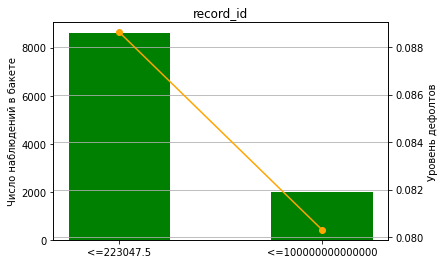

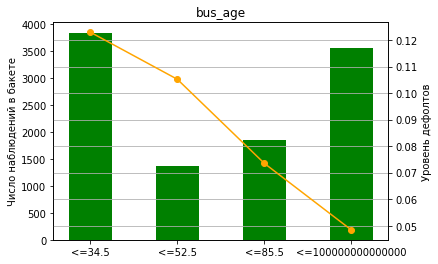

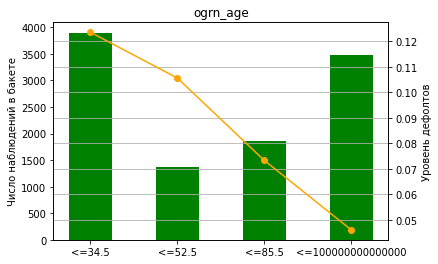

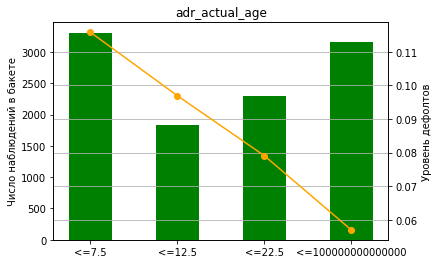

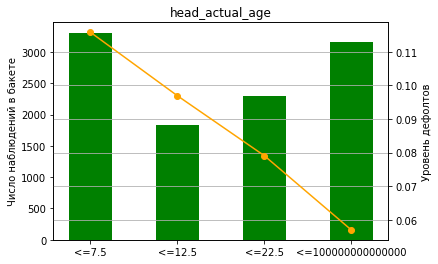

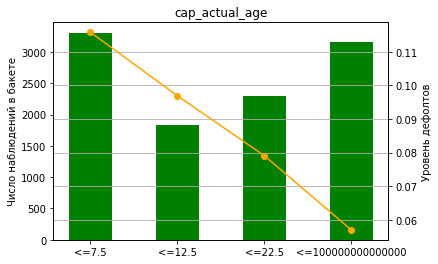

No binning for variable ul_staff_range


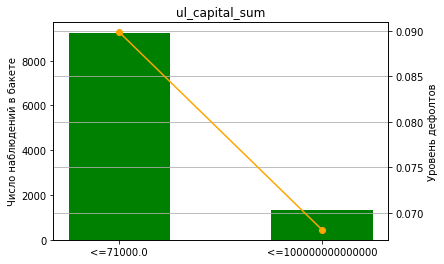

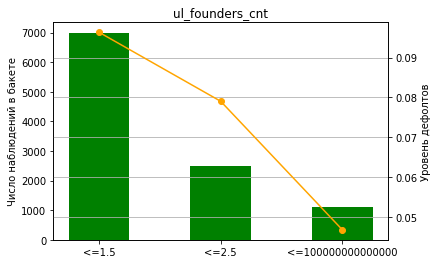

No binning for variable ul_branch_cnt


In [ ]:
binning_barchart(bins)

### Отбор признаков


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

Экспериментально было подобрано, что 4 признака в данной задаче для данных без фин отчетности является оптимальным и позволяет убрать все коррелирующие признаки

In [ ]:
FEATURE_COUNT = 4
N_SPLITS = 3

In [ ]:
y_train_woe_ip = X_train_woe_ip['default_12m']
y_test_woe_ip = X_test_woe_ip['default_12m']
X_train_woe_ip.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_ip.drop(['default_12m'], axis = 1, inplace = True)

In [ ]:
y_test_woe_ip

1192     0
9209     0
4485     0
19047    0
21050    0
        ..
28628    0
20855    0
25771    0
5735     1
4229     0
Name: default_12m, Length: 4544, dtype: int64

Запустим метод  Forward Selection для отбора признаков.

In [ ]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT , 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_ip, y_train_woe_ip)

Выведем отобранные признаки

In [ ]:
selector.subsets_[4]

{'avg_score': 0.6465186601967158,
 'cv_scores': array([0.62578904, 0.63635257, 0.67741437]),
 'feature_idx': (2, 3, 4, 7),
 'feature_names': ('ogrn_age_woe',
  'adr_actual_age_woe',
  'head_actual_age_woe',
  'ul_founders_cnt_woe')}

Построим карту корреляций для выбранных признаков.

In [ ]:
top_feat = list(selector.subsets_[FEATURE_COUNT]['feature_names'])
X_train_woe_ip[top_feat].corr()

ogrn_age_woe  ...  ul_founders_cnt_woe
ogrn_age_woe             1.000000  ...             0.138293
adr_actual_age_woe       0.159345  ...            -0.012590
head_actual_age_woe      0.159345  ...            -0.012590
ul_founders_cnt_woe      0.138293  ...             1.000000

[4 rows x 4 columns]

Все корреляции меньше 0.5. <br>Эффективность моделей бинарной классификации наилучшим образом оценивает метрика ROC/AUC (<b>Gini</b>). Поэтому оценим значимость каждого признака, вычислив коэффициент <b>Gini</b>.

In [ ]:
gini_features = pd.DataFrame(index=top_feat, columns = ['Gini'])
for feat in top_feat:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_ip.loc[:, feat].values.reshape(-1,1), y_train_woe_ip)
    preds_train = logreg.predict_proba(X_train_woe_ip.loc[:, feat].values.reshape(-1,1))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_ip, preds_train) - 1

In [ ]:
gini_features

Gini
ogrn_age_woe          0.229666
adr_actual_age_woe    0.165278
head_actual_age_woe   0.165278
ul_founders_cnt_woe  0.0870046

In [ ]:
X_train_woe_ip_final = X_train_woe_ip[top_feat]
X_test_woe_ip_final = X_test_woe_ip[top_feat]

In [ ]:
X_train_woe_ip_final

ogrn_age_woe  ...  ul_founders_cnt_woe
14323     -0.391808  ...            -0.111593
21910      0.677371  ...             0.103912
2472      -0.216575  ...             0.103912
8708       0.677371  ...             0.656191
22270     -0.391808  ...             0.103912
...             ...  ...                  ...
11028      0.677371  ...             0.103912
28670      0.183628  ...             0.103912
11442      0.677371  ...            -0.111593
1840      -0.391808  ...            -0.111593
15530      0.677371  ...             0.103912

[10601 rows x 4 columns]

### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_ip_final, y_train_woe_ip):
        
        X_train, X_test = X_train_woe_ip_final.iloc[train_index,:], X_train_woe_ip_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_ip.iloc[train_index], y_train_woe_ip.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

In [ ]:
X_train

ogrn_age_woe  ...  ul_founders_cnt_woe
21910      0.677371  ...             0.103912
22270     -0.391808  ...             0.103912
18433     -0.391808  ...            -0.111593
9955      -0.391808  ...            -0.111593
16422      0.677371  ...            -0.111593
...             ...  ...                  ...
25542     -0.391808  ...            -0.111593
11028      0.677371  ...             0.103912
28670      0.183628  ...             0.103912
11442      0.677371  ...            -0.111593
1840      -0.391808  ...            -0.111593

[7068 rows x 4 columns]

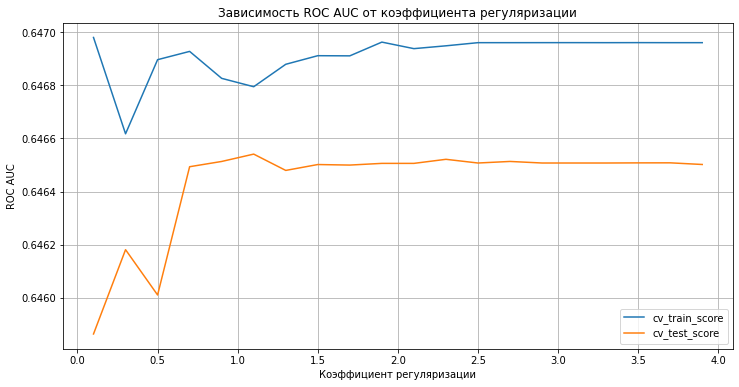

In [ ]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [ ]:
print("Наилучший коэффициент L2 - регуляризации:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент L2 - регуляризации: 1.1000000000000003


### Строим Лассо регрессию

Обучаем модель на всей обучащей выборке (без валидации)

In [ ]:
logreg_ip = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.3)
logreg_ip.fit(X_train_woe_ip_final, y_train_woe_ip)
y_pred = logreg_ip.predict_proba(X_test_woe_ip_final)[:,1]
y_pred_train = logreg_ip.predict_proba(X_train_woe_ip_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe_ip, y_pred))
print("ROC AUC train:", roc_auc_score(y_train_woe_ip, y_pred_train))

ROC AUC val: 0.6447128320910525
ROC AUC train: 0.6464573682097674


### Модель для данных с фин отчетностью

Проделаем аналогичные действия для данных с фин отчетностью.

In [ ]:
train_df_phys['ul_strategic_flg'].value_counts()

0    17247
1        3
Name: ul_strategic_flg, dtype: int64

Убираем ul_strategic_flg так как практически константная переменная, убираем ul_branch_cnt так как не биннаризуется

In [ ]:
train_df_phys.drop(['ul_strategic_flg', 'ul_branch_cnt'], axis = 1, inplace = True)

In [ ]:
train_df_phys = train_df_phys.astype('float32')
train_df_phys = train_df_phys.replace([np.inf, -np.inf], 0)
X_phys = train_df_phys.drop(['default_12m'], axis = 1)
y_phys = train_df_phys['default_12m']

Разделяем данные на обучающую и валидационную выборки

In [ ]:
X_train_phys, X_test_phys, y_train_phys, y_test_phys = train_test_split(X_phys, y_phys, test_size=0.3, random_state=42)

In [ ]:
train_df_phys

record_id  ar_net_profit  ...    r_26_a       r_27_a
0            7.0      1198000.0  ...  0.151618     0.637942
3           22.0      1919000.0  ...  0.032022     1.162377
4           23.0       711000.0  ...  0.060942     0.000000
9           40.0      2135000.0  ...  0.712844  1898.461548
10          54.0       104000.0  ...  0.396952     7.622142
...          ...            ...  ...       ...          ...
32388   274557.0            0.0  ...  0.277252     2.836769
32390   274590.0       228000.0  ...  0.592035     0.000000
32391   274593.0       636000.0  ...  0.314027     0.000000
32393   274611.0        88000.0  ...  3.783448     5.537813
32394   274623.0      1489000.0  ...  0.873490    15.477419

[17250 rows x 50 columns]

In [ ]:
X_train_phys['default_12m'] = y_train_phys
X_test_phys['default_12m'] = y_test_phys

In [ ]:
X_train_phys

record_id  ar_net_profit  ...     r_27_a  default_12m
569       4785.0     -6290000.0  ...   2.918473          0.0
19559   165616.0      4952000.0  ...  11.502573          0.0
3211     26860.0     10397000.0  ...  44.150913          0.0
7233     60823.0        -9000.0  ...  32.000000          0.0
14117   119530.0     19572000.0  ...   0.000000          0.0
...          ...            ...  ...        ...          ...
21252   180032.0      1538000.0  ...   0.000000          0.0
22510   190806.0     14616000.0  ...  33.665726          0.0
10172    85307.0       208000.0  ...  28.684502          0.0
1603     13457.0       433000.0  ...  14.571116          0.0
29700   251605.0      6367000.0  ...   0.000000          0.0

[12075 rows x 50 columns]

Проводим бинаризацию признаков

In [ ]:
binner_phys = Binner()
bins = binner_phys.fit(X_train_phys, 'default_12m')
X_train_woe_phys = binner_phys.transform(X_train_phys)
X_test_woe_phys = binner_phys.transform(X_test_phys)

In [ ]:
X_train_woe_phys

record_id_woe  ar_net_profit_woe  ...  r_27_a_woe  default_12m
569         0.034691          -0.542390  ...    0.201925          0.0
19559       0.034691           1.588081  ...    0.201925          0.0
3211        0.034691           1.588081  ...    0.201925          0.0
7233        0.034691          -0.542390  ...    0.201925          0.0
14117       0.034691           1.588081  ...   -0.175299          0.0
...              ...                ...  ...         ...          ...
21252       0.034691          -0.163680  ...   -0.175299          0.0
22510       0.034691           1.588081  ...    0.201925          0.0
10172       0.034691          -0.163680  ...    0.201925          0.0
1603        0.034691          -0.163680  ...    0.201925          0.0
29700      -0.273965           1.588081  ...   -0.175299          0.0

[12075 rows x 50 columns]

Выведем результат бинаризации

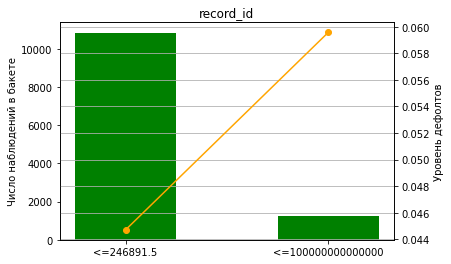

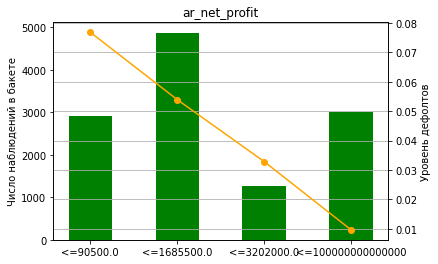

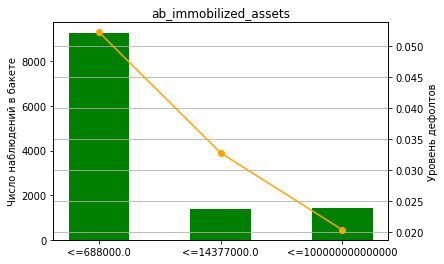

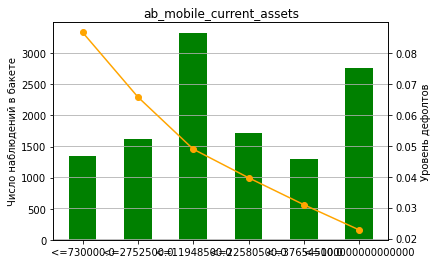

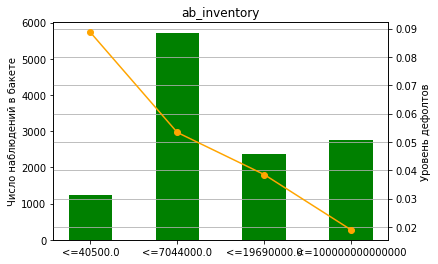

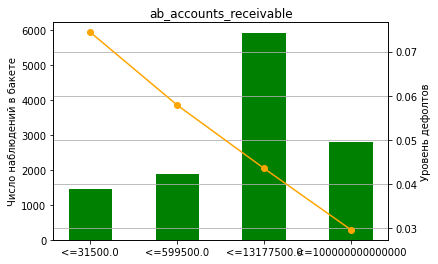

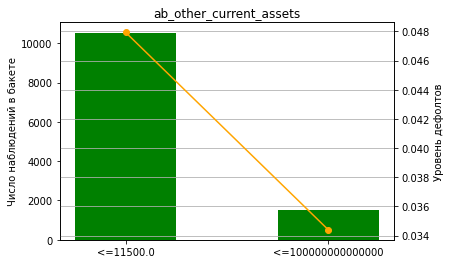

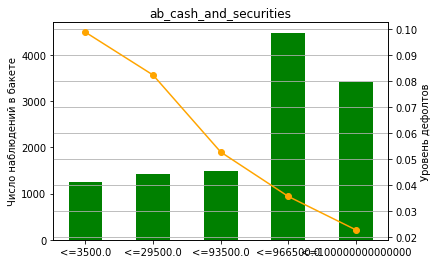

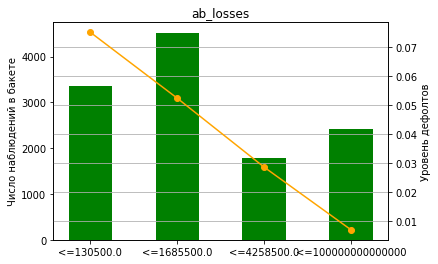

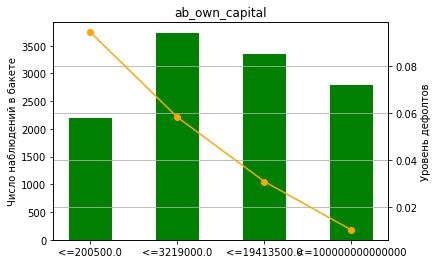

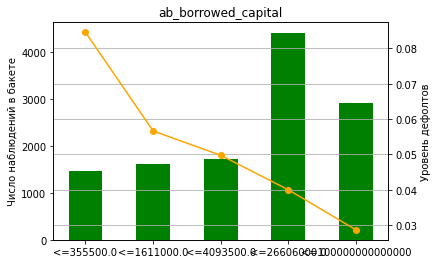

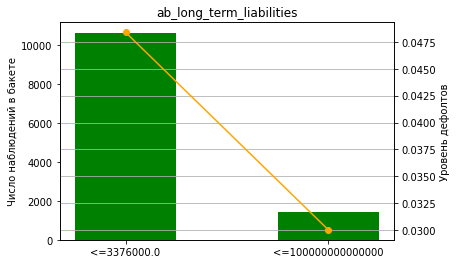

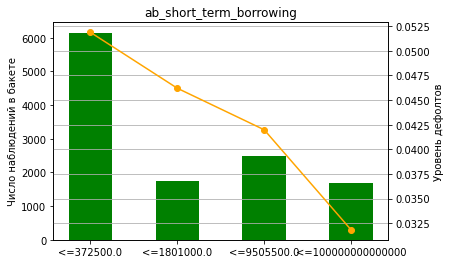

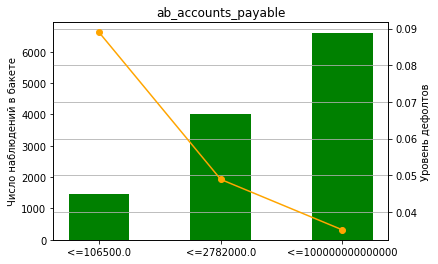

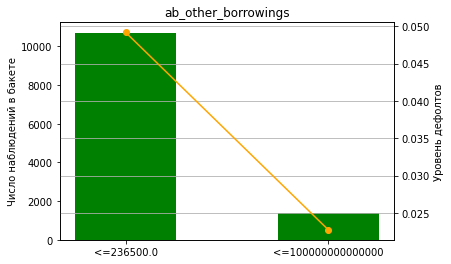

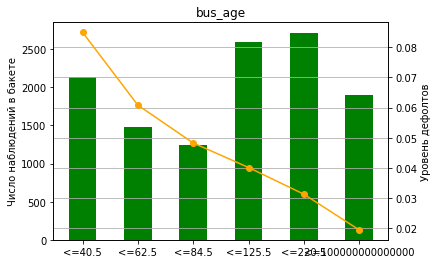

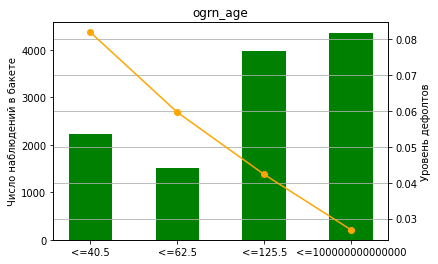

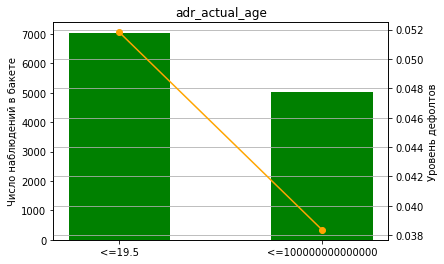

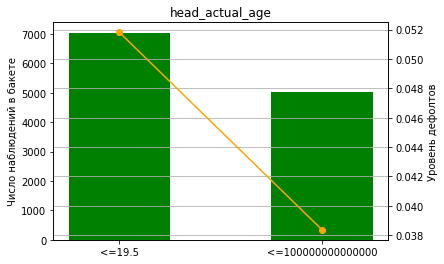

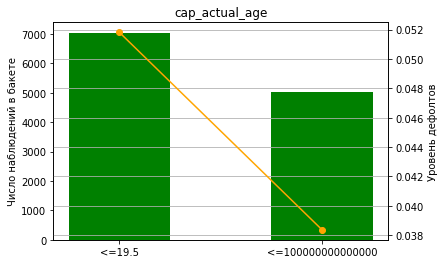

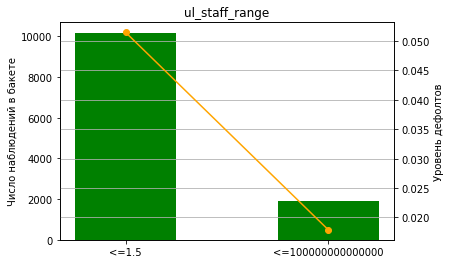

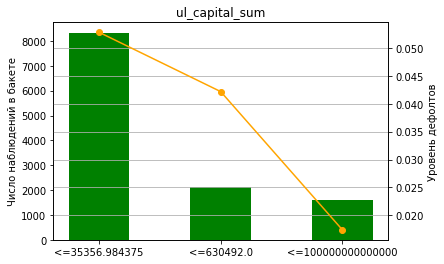

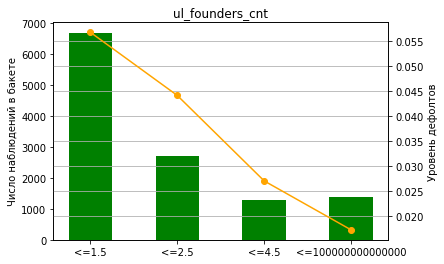

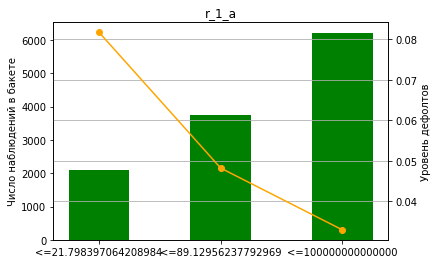

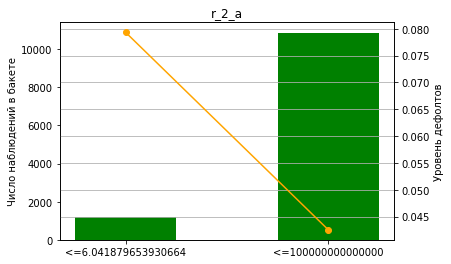

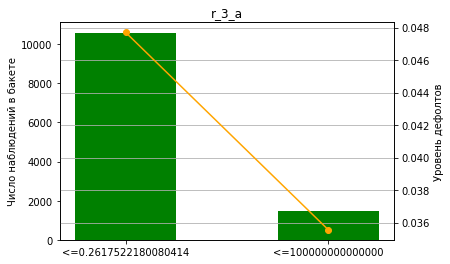

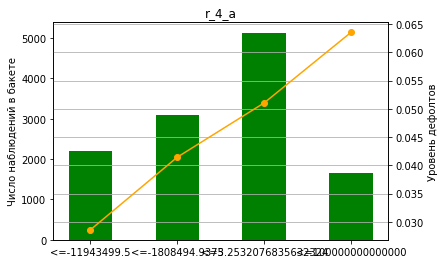

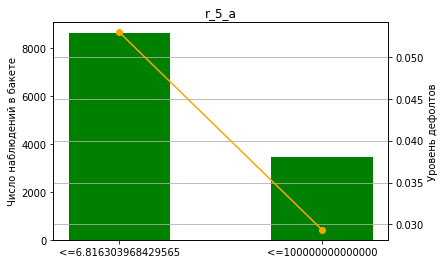

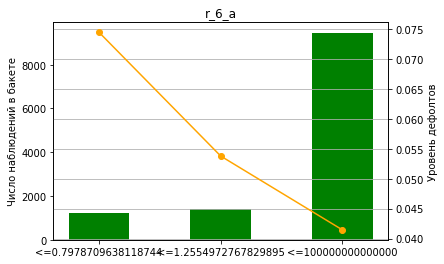

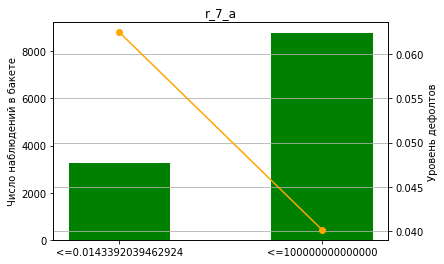

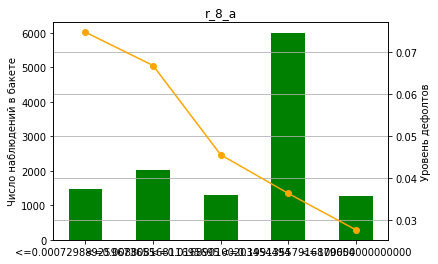

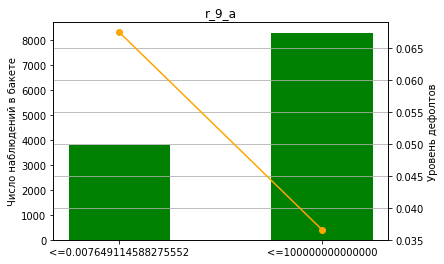

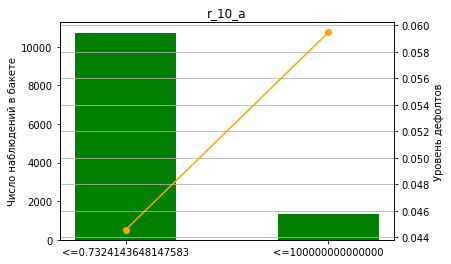

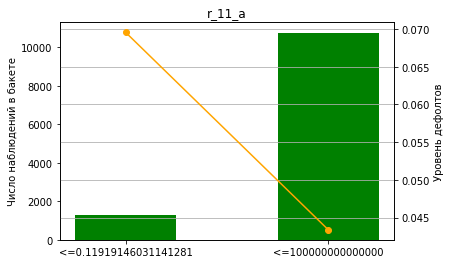

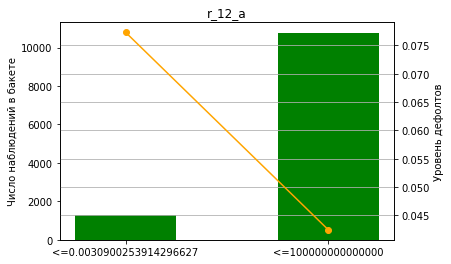

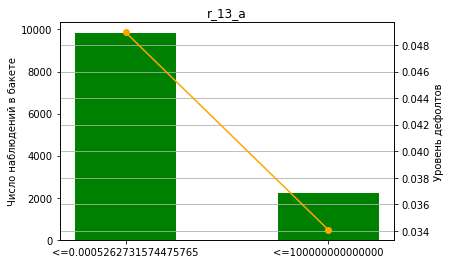

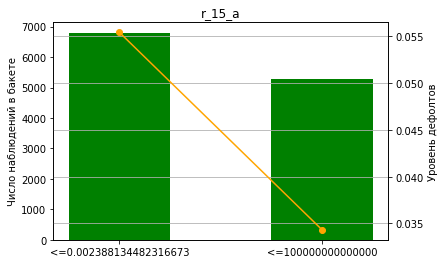

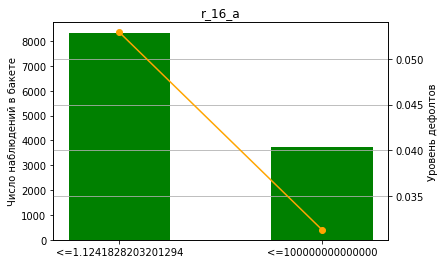

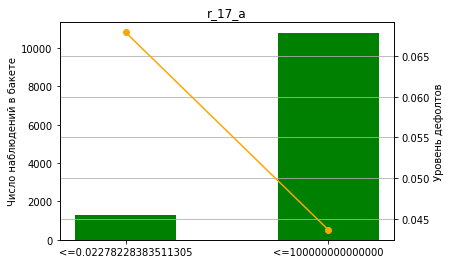

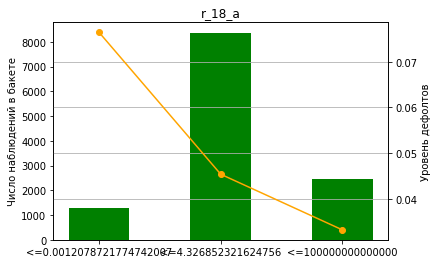

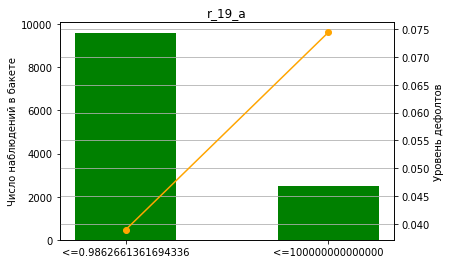

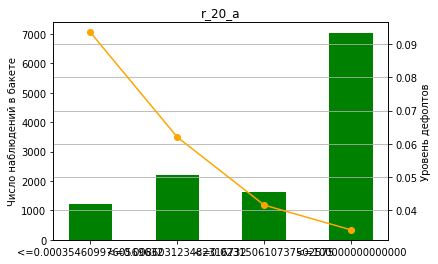

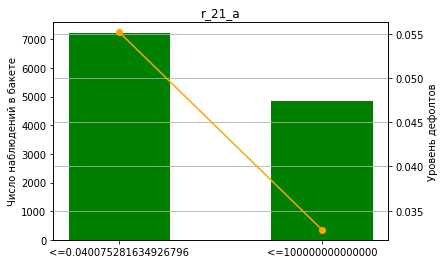

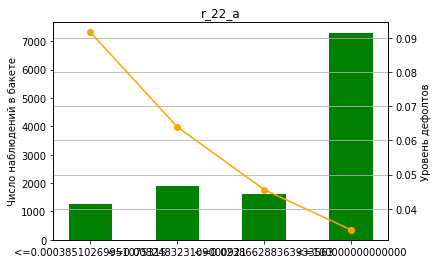

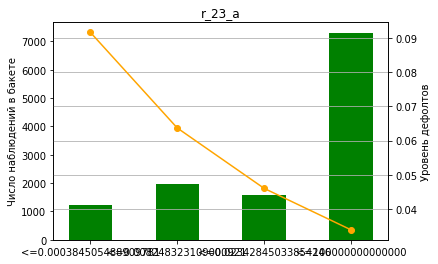

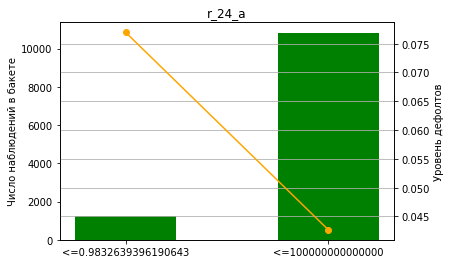

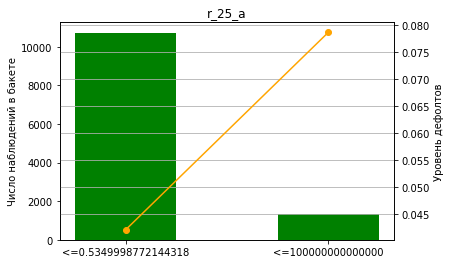

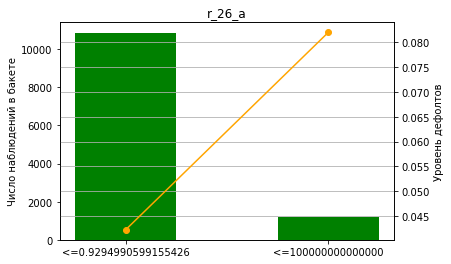

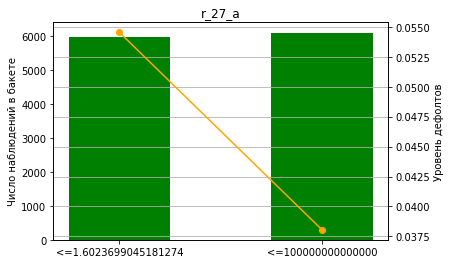

In [ ]:
binning_barchart(bins)

### Отбор признаков

In [ ]:
FEATURE_COUNT = 12

In [ ]:
y_train_woe_phys = X_train_woe_phys['default_12m']
y_test_woe_phys = X_test_woe_phys['default_12m']
X_train_woe_phys.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_phys.drop(['default_12m'], axis = 1, inplace = True)

In [ ]:
X_train_woe_phys

record_id_woe  ar_net_profit_woe  ...  r_26_a_woe  r_27_a_woe
569         0.034691          -0.542390  ...    0.093967    0.201925
19559       0.034691           1.588081  ...    0.093967    0.201925
3211        0.034691           1.588081  ...    0.093967    0.201925
7233        0.034691          -0.542390  ...   -0.615763    0.201925
14117       0.034691           1.588081  ...    0.093967   -0.175299
...              ...                ...  ...         ...         ...
21252       0.034691          -0.163680  ...    0.093967   -0.175299
22510       0.034691           1.588081  ...    0.093967    0.201925
10172       0.034691          -0.163680  ...    0.093967    0.201925
1603        0.034691          -0.163680  ...    0.093967    0.201925
29700      -0.273965           1.588081  ...    0.093967   -0.175299

[12075 rows x 49 columns]

In [ ]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT, 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_phys, y_train_woe_phys)

Выведем отобранные признаки:

In [ ]:
selector.subsets_[FEATURE_COUNT]

{'avg_score': 0.7318960937594823,
 'cv_scores': array([0.74826064, 0.7123992 , 0.73502844]),
 'feature_idx': (0, 1, 7, 9, 12, 15, 17, 21, 22, 23, 36, 40),
 'feature_names': ('record_id_woe',
  'ar_net_profit_woe',
  'ab_cash_and_securities_woe',
  'ab_own_capital_woe',
  'ab_short_term_borrowing_woe',
  'bus_age_woe',
  'adr_actual_age_woe',
  'ul_capital_sum_woe',
  'ul_founders_cnt_woe',
  'r_1_a_woe',
  'r_15_a_woe',
  'r_19_a_woe')}

In [ ]:
X_train_woe_ip

record_id_woe  bus_age_woe  ...  ul_capital_sum_woe  ul_founders_cnt_woe
14323       -0.01949    -0.385900  ...           -0.034298            -0.111593
21910       -0.01949     0.626482  ...            0.260976             0.103912
2472        -0.01949    -0.212093  ...           -0.034298             0.103912
8708        -0.01949     0.626482  ...           -0.034298             0.656191
22270       -0.01949    -0.385900  ...           -0.034298             0.103912
...              ...          ...  ...                 ...                  ...
11028       -0.01949     0.626482  ...           -0.034298             0.103912
28670        0.08588     0.181061  ...           -0.034298             0.103912
11442       -0.01949     0.626482  ...           -0.034298            -0.111593
1840        -0.01949    -0.385900  ...           -0.034298            -0.111593
15530       -0.01949     0.626482  ...           -0.034298             0.103912

[10601 rows x 8 columns]

In [ ]:
top_feat_phys = list(selector.subsets_[FEATURE_COUNT]['feature_names'])

Построим карту корреляций выбранных признаков. Проверим, чтобы между любыми двумя признаками не было высокой корреляции

In [ ]:
X_train_woe_phys[top_feat_phys].corr()

record_id_woe  ...  r_19_a_woe
record_id_woe                     1.000000  ...    0.003477
ar_net_profit_woe                 0.003504  ...    0.030194
ab_cash_and_securities_woe        0.011928  ...    0.499413
ab_own_capital_woe               -0.001484  ...    0.021244
ab_short_term_borrowing_woe       0.005280  ...   -0.099888
bus_age_woe                       0.009032  ...    0.048446
adr_actual_age_woe               -0.001451  ...    0.005980
ul_capital_sum_woe                0.000987  ...    0.018548
ul_founders_cnt_woe              -0.004496  ...    0.076326
r_1_a_woe                         0.004309  ...    0.101551
r_15_a_woe                       -0.003735  ...    0.009740
r_19_a_woe                        0.003477  ...    1.000000

[12 rows x 12 columns]

Так как признак ab_own_capital сильно коррелирует с ar_net_profit, то удалим один из них

In [ ]:
top_feat_phys.remove('ab_own_capital_woe')

In [ ]:
X_train_woe_phys_final = X_train_woe_phys[top_feat_phys]
X_test_woe_phys_final = X_test_woe_phys[top_feat_phys]

Посчитаем коэффициент Джини для выбранных признаков

In [ ]:
gini_features = pd.DataFrame(index=top_feat_phys, columns = ['Gini'])
for feat in top_feat_phys:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_phys_final.loc[:, feat].values.reshape(-1,1), y_train_woe_phys)
    preds_train = logreg.predict_proba((X_train_woe_phys_final.loc[:, feat].values.reshape(-1,1)))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_phys, preds_train) - 1

In [ ]:
gini_features

Gini
record_id_woe                0.0307983
ar_net_profit_woe             0.303107
ab_cash_and_securities_woe    0.296843
ab_short_term_borrowing_woe  0.0817229
bus_age_woe                   0.267176
adr_actual_age_woe           0.0741965
ul_capital_sum_woe            0.116619
ul_founders_cnt_woe           0.161271
r_1_a_woe                     0.196017
r_15_a_woe                    0.118017
r_19_a_woe                    0.130999

Признаки с Джини < 5% удаляем, так как у них низкая предсказательная способность.

In [ ]:
X_train_woe_phys_final = X_train_woe_phys[top_feat_phys]
X_test_woe_phys_final = X_test_woe_phys[top_feat_phys]

In [ ]:
X_train_woe_phys_final

record_id_woe  ar_net_profit_woe  ...  r_15_a_woe  r_19_a_woe
569         0.034691          -0.542390  ...    0.308489   -0.507929
19559       0.034691           1.588081  ...    0.308489    0.178092
3211        0.034691           1.588081  ...   -0.192376   -0.507929
7233        0.034691          -0.542390  ...   -0.192376    0.178092
14117       0.034691           1.588081  ...   -0.192376    0.178092
...              ...                ...  ...         ...         ...
21252       0.034691          -0.163680  ...    0.308489    0.178092
22510       0.034691           1.588081  ...   -0.192376   -0.507929
10172       0.034691          -0.163680  ...   -0.192376    0.178092
1603        0.034691          -0.163680  ...   -0.192376    0.178092
29700      -0.273965           1.588081  ...   -0.192376    0.178092

[12075 rows x 11 columns]

### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_phys_final, y_train_woe_phys):
        
        X_train, X_test = X_train_woe_phys_final.iloc[train_index,:], X_train_woe_phys_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_phys.iloc[train_index], y_train_woe_phys.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

In [ ]:
y_test

3211     0.0
3040     0.0
5466     1.0
6004     0.0
31112    0.0
        ... 
9518     0.0
1440     0.0
3174     0.0
15646    0.0
21252    0.0
Name: default_12m, Length: 4025, dtype: float32

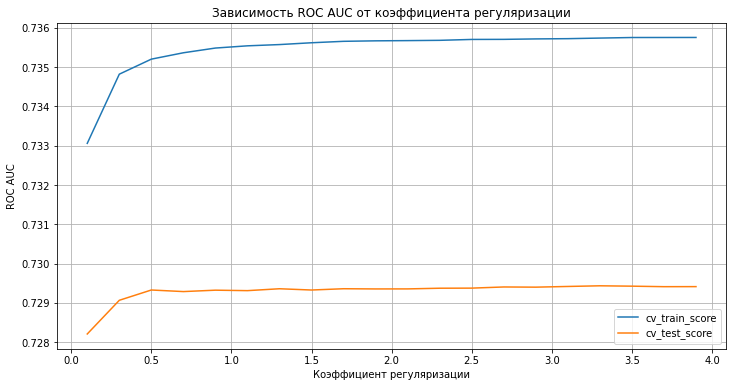

In [ ]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [ ]:
print("Наилучший коэффициент регуляризации из рассмотренных:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент регуляризации из рассмотренных: 3.3000000000000007


Обучаем финальную модель на всех обучающих данных (без валидации)

In [ ]:
logreg_phys = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.1)
logreg_phys.fit(X_train_woe_phys_final, y_train_woe_phys)
y_pred = logreg_phys.predict_proba(X_test_woe_phys_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe_phys, y_pred))

ROC AUC val: 0.6986347303758449


### Формирование файла с ответом

Разделим тестовые данные на данные с фин отчетностью и без нее:

In [ ]:
test_df_ip = test_df_new[test_df_new['ar_net_profit'].isnull()]
test_df_phys = test_df_new[~test_df_new['ar_net_profit'].isnull()]

In [ ]:
record_id_ip = test_df_ip['record_id']
record_id_phys = test_df_phys['record_id']

Подготовим тестовые данные для WOE трансформации

In [ ]:
test_df_phys = test_df_phys.astype('float32')
test_df_phys = test_df_phys.replace([np.inf, -np.inf], 0)
test_df_phys = test_df_phys.fillna(0)

Применим WOE трансформацию для тестовых данных

In [ ]:
test_df_ip = binner_ip.transform(test_df_ip[X_train_ip.columns])[top_feat]
test_df_phys = binner_phys.transform(test_df_phys[X_train_phys.columns])[top_feat_phys]

###Подбор трешхолда

Так как мы знаем распределение дефолтов/не дефолтов на тестовой выборке (а именно 50/50), то попробуем подобрать порог семплируя из размеченных данных 200 дефолтов и 200 не дефолтов. Для каждого семла будем перебирать пороги от 0.05 до 0.15 c шагом 0.005 и будем запоминать тот, который дает наилучший accuracy. В результате работы функции получится N (количество семлов) порогов. Функция возвращает медиану из N порогов.

In [ ]:
X_ip_with_labels = X_train_woe_ip_final.copy()
X_ip_with_labels['default_12m'] = y_ip
X_phys_with_labels = X_train_woe_phys_final.copy()
X_phys_with_labels['default_12m'] = y_phys

In [ ]:
X_ip_with_labels

ogrn_age_woe  adr_actual_age_woe  ...  ul_founders_cnt_woe  default_12m
14323     -0.391808           -0.120411  ...            -0.111593            0
21910      0.677371           -0.318294  ...             0.103912            0
2472      -0.216575            0.453953  ...             0.103912            0
8708       0.677371            0.102694  ...             0.656191            0
22270     -0.391808            0.102694  ...             0.103912            0
...             ...                 ...  ...                  ...          ...
11028      0.677371            0.453953  ...             0.103912            0
28670      0.183628            0.453953  ...             0.103912            0
11442      0.677371            0.102694  ...            -0.111593            0
1840      -0.391808           -0.318294  ...            -0.111593            1
15530      0.677371            0.102694  ...             0.103912            0

[10601 rows x 5 columns]

In [ ]:
def find_cutoff(data, model, N):
    cutoff = []
    acc = []
    for i in range(N):
        idx_1 = data[data['default_12m'] == 1].shape[0]
        idx_0 = data[data['default_12m'] == 0].shape[0]
        idx_1 = np.random.randint(0, idx_1, 200)
        idx_0 = np.random.randint(0, idx_0, 200)
    
        data_1 = data[data['default_12m'] == 1].iloc[idx_1,]
        data_0 = data[data['default_12m'] == 0].iloc[idx_0,]
        data_1.drop(['default_12m'], axis = 1, inplace = True)
        data_0.drop(['default_12m'], axis = 1, inplace = True)
    
        pred_1 = model.predict_proba(data_1)[:,1]
        pred_0 = model.predict_proba(data_0)[:,1]
        
        best_acc = 0
        best_cutoff = 0
        for cur_cutoff in np.linspace(0.05, 0.15, 21):
            true_0 = 200 - np.sum(pred_0 > cur_cutoff)
            true_1 = np.sum(pred_1 > cur_cutoff)
            cur_acc = (true_0 + true_1) / 400
            if cur_acc > best_acc:
                best_acc = cur_acc
                best_cutoff = cur_cutoff
        acc.append(best_acc)
        cutoff.append(best_cutoff)
    return np.median(cutoff)

In [ ]:
cutoff_phys = find_cutoff(X_phys_with_labels, logreg_phys, 20)
print("Cutoff с фин отчетностью:", cutoff_phys)

Cutoff с фин отчетностью: 0.052500000000000005


In [ ]:
cutoff_ip = find_cutoff(X_ip_with_labels, logreg_ip, 20)
print("Cutoff без фин отчетности:", cutoff_ip)

Cutoff без фин отчетности: 0.08


Модель для данных без фин отчетности обученная на всех размеченных данных

In [ ]:
X_ip['default_12m'] = y_ip
data_binned_ip = binner_ip.transform(X_ip)

In [ ]:
data_binned_ip

record_id_woe  bus_age_woe  ...  ul_founders_cnt_woe  default_12m
1           -0.01949     0.626482  ...             0.656191            0
2           -0.01949    -0.385900  ...             0.103912            0
5           -0.01949     0.626482  ...            -0.111593            0
6           -0.01949     0.626482  ...             0.656191            0
7           -0.01949    -0.385900  ...             0.103912            0
...              ...          ...  ...                  ...          ...
32383        0.08588     0.626482  ...             0.103912            0
32384        0.08588    -0.385900  ...            -0.111593            0
32387        0.08588     0.626482  ...             0.656191            0
32389        0.08588    -0.385900  ...             0.656191            0
32392        0.08588    -0.385900  ...            -0.111593            0

[15145 rows x 9 columns]

In [ ]:
logreg_ip = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.7)
logreg_ip.fit(data_binned_ip.drop(['default_12m'], axis=1)[top_feat], data_binned_ip['default_12m'])
y_pred_ip = logreg_ip.predict_proba(test_df_ip)[:,1]
predict_ip = (y_pred_ip > cutoff_ip).astype(int)

Модель для данных с фин отчетности обученная на всех размеченных данных

In [ ]:
X_phys['default_12m'] = y_phys
data_binned_phys = binner_phys.transform(X_phys)

In [ ]:
data_binned_phys
logreg_phys = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.5)
logreg_phys.fit(data_binned_phys.drop(['default_12m'], axis=1)[top_feat_phys], 
                data_binned_phys['default_12m'])
y_pred_phys = logreg_phys.predict_proba(test_df_phys)[:,1]
predict_phys = (y_pred_phys > cutoff_phys).astype(int)

In [ ]:
logreg_phys = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.5)
logreg_phys.fit(data_binned_phys.drop(['default_12m'], axis=1)[top_feat_phys], 
                data_binned_phys['default_12m'])
y_pred_phys = logreg_phys.predict_proba(test_df_phys)[:,1]
predict_phys = (y_pred_phys > cutoff_phys).astype(int)

In [ ]:
predict_phys

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])

Формирование ответа

In [ ]:
ans_ip = dict(zip(record_id_ip, predict_ip))
ans_phys = dict(zip(record_id_phys, predict_phys))
ans_dict = ans_ip.copy()
ans_dict.update(ans_phys)

In [ ]:
answ_df = test_df[['record_id']]
answ_df['predict'] = answ_df['record_id']
answ_df['predict'] = answ_df['predict'].map(ans_dict)
answ_df = answ_df.rename(columns = {'record_id': 'id'})

In [ ]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

[Текст ссылки](https://)Для загрузки своего результата на https://dsbattle.com/hackathons/juniords/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)

P.S. еще немного картиночек про то как модель ранжирует объекты

Модель для данных без фин отчетности:

In [ ]:
X_ip_with_labels = X_train_woe_ip_final.copy()
X_ip_with_labels['default_12m'] = y_train_woe_ip
X_ip_1 = X_ip_with_labels[X_ip_with_labels['default_12m'] == 1].iloc[:200,]
X_ip_0 = X_ip_with_labels[X_ip_with_labels['default_12m'] == 0].iloc[:200,]
X_ip_1.drop(['default_12m'], axis = 1, inplace = True)
X_ip_0.drop(['default_12m'], axis = 1, inplace = True)

In [ ]:
X_ip_with_labels

ogrn_age_woe  adr_actual_age_woe  ...  ul_founders_cnt_woe  default_12m
14323     -0.391808           -0.120411  ...            -0.111593            0
21910      0.677371           -0.318294  ...             0.103912            0
2472      -0.216575            0.453953  ...             0.103912            0
8708       0.677371            0.102694  ...             0.656191            0
22270     -0.391808            0.102694  ...             0.103912            0
...             ...                 ...  ...                  ...          ...
11028      0.677371            0.453953  ...             0.103912            0
28670      0.183628            0.453953  ...             0.103912            0
11442      0.677371            0.102694  ...            -0.111593            0
1840      -0.391808           -0.318294  ...            -0.111593            1
15530      0.677371            0.102694  ...             0.103912            0

[10601 rows x 5 columns]

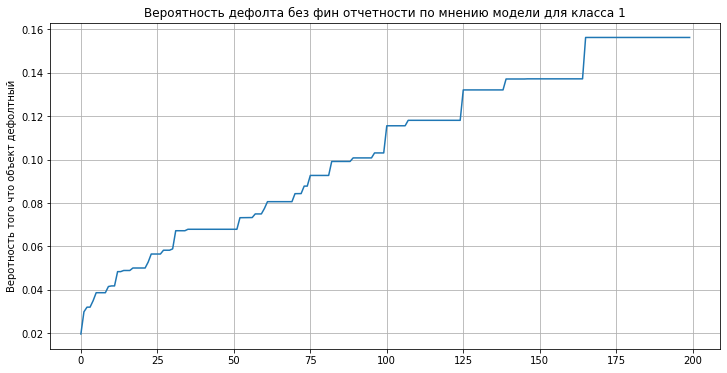

In [ ]:
pred_ip_1 = logreg_ip.predict_proba(X_ip_1)[:,1]
plt.plot(np.arange(200), np.sort(pred_ip_1))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта без фин отчетности по мнению модели для класса 1')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

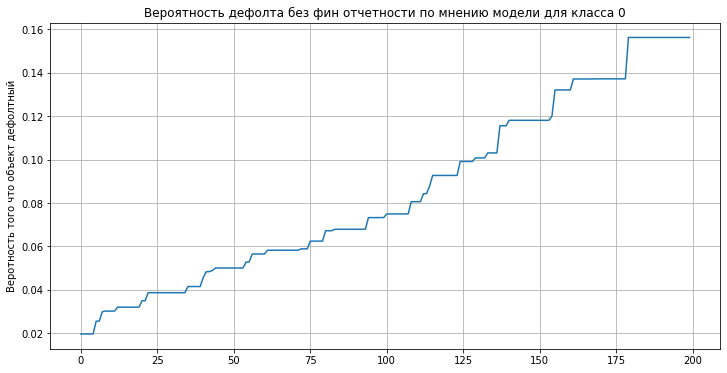

In [ ]:
pred_ip_0 = logreg_ip.predict_proba(X_ip_0)[:,1]
plt.plot(np.arange(200), np.sort(pred_ip_0))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта без фин отчетности по мнению модели для класса 0')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

Вывод: из графиков видно, что модель присваивает бОльшему количеству объектов более низкую вероятность дефолта, если объекты имеют истинный таргет 0(не дефолт). И бОльшему количеству объектов более высокую вероятность дефолта, если объекты имеют истинный таргет 1 (дефолт).

Модель для данных без фин отчетности

In [ ]:
X_phys_with_labels = X_train_woe_phys_final.copy()
X_phys_with_labels['default_12m'] = y_train_woe_phys
X_phys_1 = X_phys_with_labels[X_phys_with_labels['default_12m'] == 1].iloc[:200,]
X_phys_0 = X_phys_with_labels[X_phys_with_labels['default_12m'] == 0].iloc[:200,]
X_phys_1.drop(['default_12m'], axis = 1, inplace = True)
X_phys_0.drop(['default_12m'], axis = 1, inplace = True)

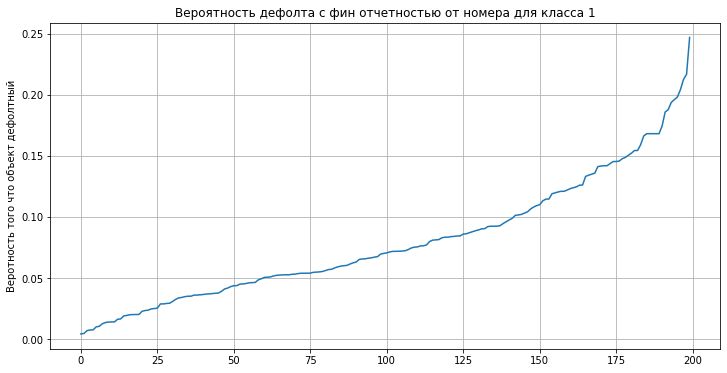

In [ ]:
pred_phys_1 = logreg_phys.predict_proba(X_phys_1)[:,1]
plt.plot(np.arange(200), np.sort(pred_phys_1))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта с фин отчетностью от номера для класса 1')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

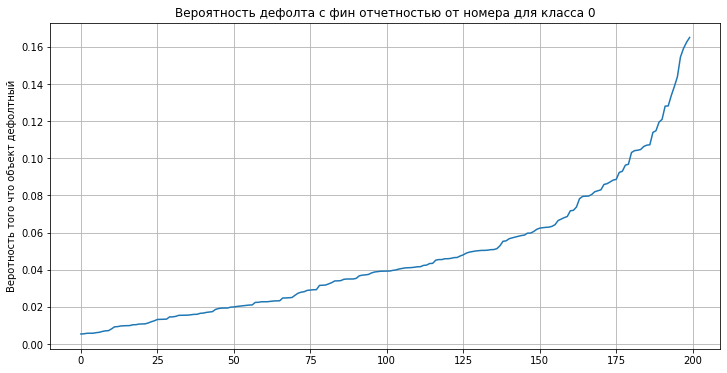

In [ ]:
pred_phys_0 = logreg_phys.predict_proba(X_phys_0)[:,1]
plt.plot(np.arange(200), np.sort(pred_phys_0))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта с фин отчетностью от номера для класса 0')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

Gradient Boosted trees is an ensemble model where each subsequent tree corrects the errors of the model. This is done by fitting trees to the residuals of the model.

Cool stuff about Boosting: in regression the residuals are actually the negative gradients of MSE. This means that the algorithm of boosting can be specialized to a gradient descent algorithm, allowing us to optimize any loss function that can be optimized via GD.

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
model = GradientBoostingRegressor(n_estimators = 100)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
def rmse(y_hat, y):
    return np.sqrt(mean_squared_error(y_hat, y))
print(f'Test R^2 score: {r2_score(model.predict(X_test), y_test):.4f}')
print(f'Test RMSE: {rmse(model.predict(X_test), y_test):.4f}')

Test R^2 score: -23.2115
Test RMSE: 0.2077


In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular

import pandas as pd
import numpy as np
import lightgbm as lgb

# For converting textual categories to integer labels 
from sklearn.preprocessing import LabelEncoder

# for creating train test split
from sklearn.model_selection import train_test_split

# specify your configurations as a dict
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':100,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}


# reading the titanic data


# data preparation

feat = ['record_id_woe',
 'ar_net_profit_woe',
 'ab_immobilized_assets_woe',
 'ab_mobile_current_assets_woe',
 'ab_inventory_woe',
 'ab_accounts_receivable_woe',
 'ab_other_current_assets_woe',
 'ab_cash_and_securities_woe',
 'ab_losses_woe',
 'ab_own_capital_woe',
 'ab_borrowed_capital_woe',
 'ab_long_term_liabilities_woe',
 'ab_short_term_borrowing_woe',
 'ab_accounts_payable_woe',
 'ab_other_borrowings_woe',
 'bus_age_woe',
 'ogrn_age_woe',
 'adr_actual_age_woe',
 'head_actual_age_woe',
 'cap_actual_age_woe',
 'ul_staff_range_woe',
 'ul_capital_sum_woe',
 'ul_founders_cnt_woe']


LEN=len(feat)



X_train,X_test,y_train,y_test = train_test_split(data_binned_phys[feat], 
                data_binned_phys['default_12m'],test_size=0.3)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)


# training the lightgbm model
model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)









# this is required as LIME requires class probabilities in case of classification example
# LightGBM directly returns probability for class 1 by default 

def prob(data):
    return np.array(list(zip(1-model.predict(data),model.predict(data))))
    


explainer = lime.lime_tabular.LimeTabularExplainer(data_binned_phys[model.feature_name()].astype(float).values,  
mode='classification',training_labels=data_binned_phys['default_12m'],feature_names=model.feature_name())


# asking for explanation for LIME model
i = 1000
exp = explainer.explain_instance(data_binned_phys.loc[i,feat].astype(float).values, prob, num_features=LEN)






[1]	valid_0's auc: 0.700036	valid_0's l2: 0.0460397
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.709222	valid_0's l2: 0.0458551
[3]	valid_0's auc: 0.715926	valid_0's l2: 0.0456718
[4]	valid_0's auc: 0.716595	valid_0's l2: 0.0455546
[5]	valid_0's auc: 0.725917	valid_0's l2: 0.0453984
[6]	valid_0's auc: 0.726951	valid_0's l2: 0.0453133
[7]	valid_0's auc: 0.728258	valid_0's l2: 0.0452022
[8]	valid_0's auc: 0.729646	valid_0's l2: 0.0451163
[9]	valid_0's auc: 0.731795	valid_0's l2: 0.0450296
[10]	valid_0's auc: 0.732971	valid_0's l2: 0.044955
[11]	valid_0's auc: 0.735649	valid_0's l2: 0.0449014
[12]	valid_0's auc: 0.73552	valid_0's l2: 0.0448777
[13]	valid_0's auc: 0.734123	valid_0's l2: 0.0448678
[14]	valid_0's auc: 0.734191	valid_0's l2: 0.0448346
[15]	valid_0's auc: 0.734567	valid_0's l2: 0.0448267
[16]	valid_0's auc: 0.734285	valid_0's l2: 0.0448124
Early stopping, best iteration is:
[11]	valid_0's auc: 0.735649	valid_0's l2: 0.0449014


In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp.save_to_file('lime32.html')

In [ ]:
df.loc[1000]


record_id                    8414
ar_revenue              9.904e+06
ar_total_expenses       9.756e+06
ar_sale_cost            9.756e+06
ar_selling_expenses             0
                          ...    
r_23_a                 0.00569569
r_24_a                   0.981818
r_25_a                   0.946508
r_26_a                   0.944925
r_27_a                    1.04994
Name: 1000, Length: 63, dtype: object

In [ ]:
data_binned_phys

record_id_woe  ar_net_profit_woe  ...  r_27_a_woe  default_12m
0           0.034691          -0.163680  ...   -0.175299          0.0
3           0.034691           0.344168  ...   -0.175299          0.0
4           0.034691          -0.163680  ...   -0.175299          0.0
9           0.034691           0.344168  ...    0.201925          0.0
10          0.034691          -0.163680  ...    0.201925          0.0
...              ...                ...  ...         ...          ...
32388      -0.273965          -0.542390  ...    0.201925          0.0
32390      -0.273965          -0.163680  ...   -0.175299          0.0
32391      -0.273965          -0.163680  ...   -0.175299          0.0
32393      -0.273965          -0.542390  ...    0.201925          1.0
32394      -0.273965          -0.163680  ...    0.201925          0.0

[17250 rows x 50 columns]

In [ ]:
!pip install shap
!pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
data = data_binned_phys
y = (data['default_12m'] == 0)  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.float, np.float]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [ ]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

array([[0.01, 0.99]])

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Using 12937 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


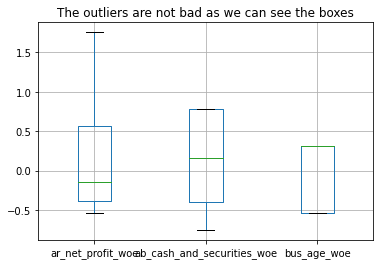

In [ ]:
plt.figure()
X_train.boxplot()
plt.title('The outliers are not bad as we can see the boxes')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
cv = StratifiedShuffleSplit(n_splits=4) 
pipe = Pipeline([('scale', StandardScaler()),
                ('clf', KNeighborsClassifier(n_jobs=-1,))])

params = {'clf__n_neighbors':[1, 3, 4, 5], 'clf__weights':['uniform', 'distance']}
search = GridSearchCV(pipe, cv=cv, param_grid=params, n_jobs=-1, verbose=10, scoring='roc_auc')
search.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    4.0s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=4, random_state=None, test_size=None,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                   

In [ ]:
results = pd.DataFrame(search.cv_results_).sort_values(by = 'rank_test_score')
results

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
4       0.031324      0.001633  ...        0.012154                1
5       0.032070      0.001874  ...        0.012154                1
2       0.032296      0.002062  ...        0.004730                3
3       0.032237      0.002238  ...        0.004730                3
6       0.030553      0.000666  ...        0.035842                5
7       0.031040      0.001476  ...        0.035842                5
0       0.044142      0.010471  ...        0.010921                7
1       0.030953      0.000755  ...        0.010921                7

[8 rows x 14 columns]

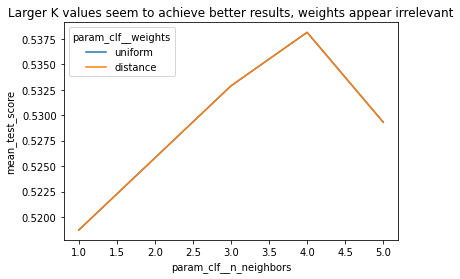

In [ ]:
import seaborn as sns
sns.lineplot(x='param_clf__n_neighbors', y='mean_test_score', hue='param_clf__weights', data=results)
plt.title('Larger K values seem to achieve better results, weights appear irrelevant')
plt.show()

In [ ]:
train_data = lgb.Dataset(X_train, free_raw_data=False, label = y_train, feature_name = X_train.columns.tolist())

In [ ]:
params = {
    'n_jobs': -1,
    'learning_rate': 0.2,
}

In [ ]:
num_round = 1000
bst = lgb.train(params, train_data, num_round)

In [ ]:
print(f'Test R^2 score: {r2_score(bst.predict(X_test), y_test):.5f}')

Test R^2 score: -29.83564


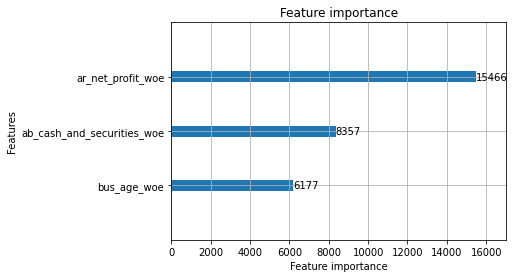

In [ ]:
lgb.plot_importance(bst)

In [ ]:
import statsmodels.api as sm
mdl = sm.OLS(y_train, X_train)     # training on train observations

fmdl = mdl.fit()

print(fmdl.summary(title='Baseline model for dataset', alpha=.01))

y_pred = fmdl.predict(X_test)   # predicted values on the testing set

print(f'Out of sample R^2 is {r2_score(y_test, y_pred):.2f}')

                               Baseline model for dataset                              
Dep. Variable:            default_12m   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              20.39
Date:                Wed, 30 Dec 2020   Prob (F-statistic):                    3.56e-13
Time:                        16:14:13   Log-Likelihood:                          1372.4
No. Observations:               11462   AIC:                                     -2739.
Df Residuals:                   11459   BIC:                                     -2717.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.005      0.995]
-------------------------

In [ ]:
mdl = sm.OLS(y_train, sm.add_constant(X_train))     # training on train observations

fmdl = mdl.fit()

print(fmdl.summary(title='Second iteration for dataset', alpha=.01))

y_pred = fmdl.predict(sm.add_constant(X_test))   # predicted values on the testing set

print(f'Out of sample R^2 is {r2_score(y_test, y_pred):.2f}')

                         Second iteration for dataset                         
Dep. Variable:            default_12m   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     89.74
Date:                Wed, 30 Dec 2020   Prob (F-statistic):           2.13e-57
Time:                        16:14:13   Log-Likelihood:                 1746.9
No. Observations:               11462   AIC:                            -3486.
Df Residuals:                   11458   BIC:                            -3456.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.005      0.995]
----------------------------------------------------------------------------------------------
const               

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 5, weights='uniform')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)   # predicted values on the testing set

print(f'\n\nOut of sample R^2 is {r2_score(y_test, y_pred):.2f}')



Out of sample R^2 is -0.12


RMSE 0.2151


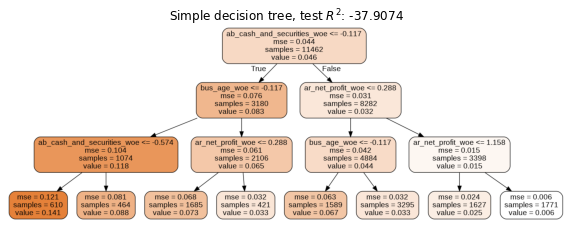

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
plt.rcParams['figure.figsize'] = (10, 7)

def plot_tree(model, X, fname = 'temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names = X.columns, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

tree1 = DecisionTreeRegressor(random_state=0, max_depth=3) 
tree1.fit(X_train, y_train)
tree1_r2 = r2_score(tree1.predict(X_test), y_test)
tree1_rmse = rmse(tree1.predict(X_test), y_test)

print(f'RMSE {tree1_rmse:.4f}')
plot_tree(tree1, X_train)
plt.axis('off')
plt.title(f"Simple decision tree, test $R^2$: {tree1_r2:.4f}")
plt.show()

In [ ]:
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [ ]:
X = X_train.values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

In [ ]:
X.shape

(11462, 3)

In [ ]:
y = y_train
np.unique(y)

array([0., 1.], dtype=float32)

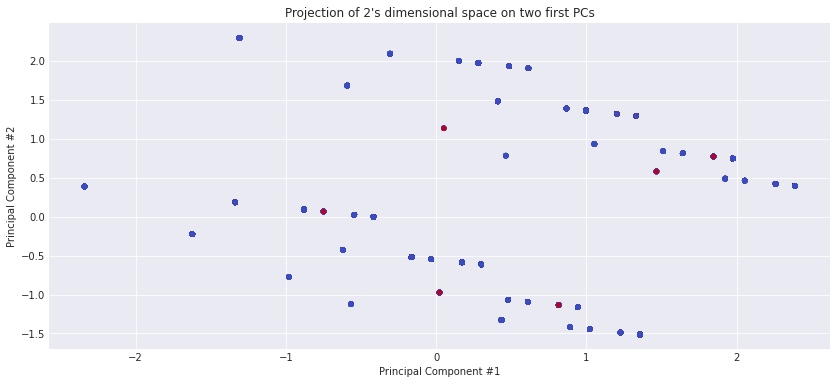

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Projection of 2\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

In [ ]:
pca = PCA(n_components=0.75, random_state=42)

X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(11462, 2)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
pca.explained_variance_ratio_[0:2]

array([0.49425094, 0.29758501])

In [ ]:
X_two_dim = X_pca[:,:2]

idx = (X_two_dim[:,0] < 50) & (X_two_dim[:,1] < 15)

X_two_dim = X_two_dim #[idx,:]

In [ ]:
X_two_dim

array([[ 0.99755409,  1.36130196],
       [ 0.43494706, -1.32707582],
       [-2.3399318 ,  0.38584344],
       ...,
       [ 2.38658945,  0.39424501],
       [ 1.20279733,  1.31987289],
       [ 2.25875119,  0.42004961]])

In [ ]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_two_dim)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

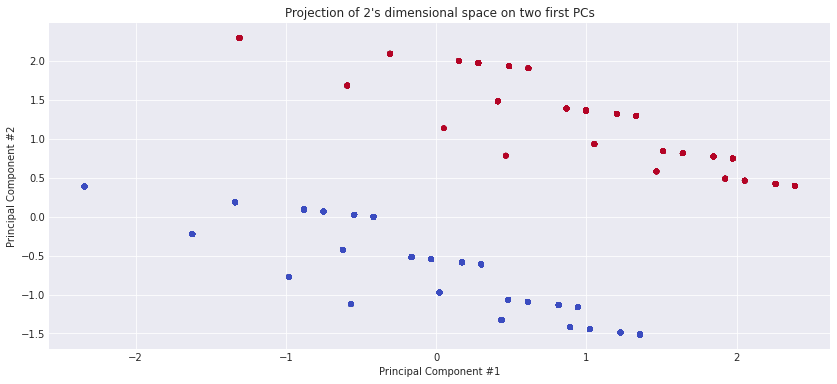

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim[:,0], X_two_dim[:,1], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 2\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

In [ ]:
kmeans.predict(X_two_dim[:1,:])

array([1], dtype=int32)

In [ ]:
a = kmeans.transform(X_two_dim[:1,:])

print(a)

[[2.3122643  0.16810539]]


In [ ]:
k_max = 20

inertia = []
for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k).fit(X_two_dim)
    inertia.append(np.sqrt(kmeans.inertia_))

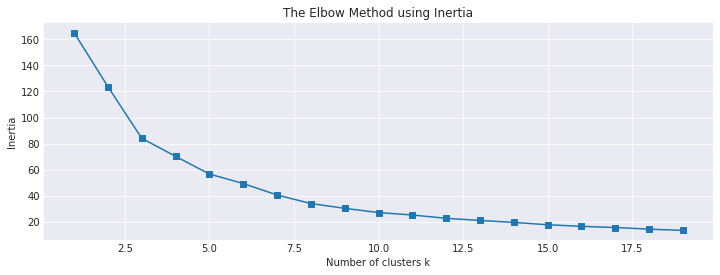

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

In [ ]:
d = {}
for k in range(2, k_max-1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

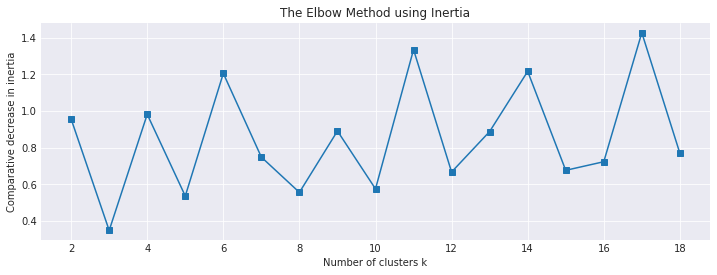

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max-1), [x for x in d.values()], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [ ]:
print('Training Feature Size: ', X_train.shape)
print('Testing Feature Size:  ', X_test.shape)
print('Training Labels Size:  ', y_train.shape)
print('Testing Labels Size:   ', y_test.shape)

Training Feature Size:  (11462, 3)
Testing Feature Size:   (4913, 3)
Training Labels Size:   (11462,)
Testing Labels Size:    (4913,)
